<a href="https://colab.research.google.com/github/heesukjang/W207_AppliedML_Fall2022/blob/main/11_13_Experiments_ImageAug_CM_CR_ROCcurve_IDC_Prediction_heesuk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## FALL 2022<br>
W207 Applied Machine Learning<br>
Heesuk Jang
 

#Predicting IDC with Breast Histopathology Images using CNN



In [1]:
import pandas as pd
import numpy as np
import os
import re
import random
import joblib
import glob
import itertools

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib.patches as patches

from sklearn.utils import shuffle
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from scipy import stats
from collections import Counter
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import *                            # confusion_matrix, log_loss, accuracy_score
from sklearn.model_selection import *                    # train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import preprocessing
from sklearn.preprocessing import *
# from sklearn.ensemble import *
from sklearn.svm import *
from sklearn.linear_model import *                       # LinearRegression
from sklearn.discriminant_analysis import *
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.plotting import plot_decision_regions

import tensorflow as tf
from tensorflow import keras
from keras import metrics
from tensorflow.keras import initializers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import RandomFlip, RandomZoom, RandomRotation, Conv2D, MaxPooling2D, AveragePooling2D, Input, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD, Adadelta, Adagrad, RMSprop
from keras.layers import ReLU, LeakyReLU
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve

tf.get_logger().setLevel('INFO')

import cv2 as cv
import skimage.io as io

import warnings
warnings.filterwarnings('ignore')

# Required to read the data from Kaggle
from google.colab import drive
# drive.mount('/content/gdrive')
# os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Kaggle"

from google.colab import drive
drive.mount('/content/gdrive')

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

Mounted at /content/gdrive


## Install Optuna and Version Check

In [2]:
# !pip install --quiet optuna
# import optuna
# optuna.__version__

## Enabling and testing the GPU

In [3]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Enabling and testing the TPU

In [4]:
# import tensorflow as tf
# print("Tensorflow version " + tf.__version__)

# try:
#   tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
#   print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
# except ValueError:
#   raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

## Observe TensorFlow speedup on GPU relative to CPU

In [5]:
# import tensorflow as tf
# import timeit

# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   print(
#       '\n\nThis error most likely means that this notebook is not '
#       'configured to use a GPU.  Change this in Notebook Settings via the '
#       'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
#   raise SystemError('GPU device not found')

# def cpu():
#   with tf.device('/cpu:0'):
#     random_image_cpu = tf.random.normal((100, 100, 100, 3))
#     net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
#     return tf.math.reduce_sum(net_cpu)

# def gpu():
#   with tf.device('/device:GPU:0'):
#     random_image_gpu = tf.random.normal((100, 100, 100, 3))
#     net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
#     return tf.math.reduce_sum(net_gpu)
  
# # We run each op once to warm up; see: https://stackoverflow.com/a/45067900
# cpu()
# gpu()

# # Run the op several times.
# print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
#       '(batch x height x width x channel). Sum of ten runs.')
# print('CPU (s):')
# cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
# print(cpu_time)
# print('GPU (s):')
# gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
# print(gpu_time)
# print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

In [6]:
# !unzip gdrive/MyDrive/Kaggle/CNN_IDC/Dataset.zip

#replace these paths with the paths of your 
val_image_directory = '/content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset/Validate'
train_image_directory = '/content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset/Train'
test_image_directory = '/content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset/Test'
directory_path = '/content/gdrive/MyDrive/Kaggle/CNN_IDC'

In [7]:
def get_paths(directory):
  all_path = []
  idc_image_path = []
  idc_image_label = []

  for dir, subdir, files in os.walk(directory):
    path = dir + "/"
    all_path.append(path)

  for i in range(len(all_path)):
    for file in os.listdir(all_path[i]):
      test = file
      path = all_path[i] + test
      if path.lower().endswith('.png'):
        idc_image_path.append(path)

  for i in range(len(idc_image_path)):
    split_test = idc_image_path[i]
    split_path = split_test.split("/")
    directory_name = split_path[7]
    idc_image_label.append('class_' + split_path[8])
  return idc_image_path, idc_image_label, directory_name

In [8]:
train_paths, train_labels, train_dir = get_paths(train_image_directory)
val_paths, val_labels, val_dir = get_paths(val_image_directory)
test_paths, test_labels, test_dir = get_paths(test_image_directory)

In [9]:
print(train_labels[:5])
print(train_labels[-5:])

print(len(train_paths), len(train_labels))
print(len(test_paths), len(test_labels))
print(len(val_paths), len(val_labels))

['class_0', 'class_0', 'class_0', 'class_0', 'class_0']
['class_1', 'class_1', 'class_1', 'class_1', 'class_1']
800 800
200 200
200 200


In [10]:
print(train_paths[:2])
print(train_labels[:10])
print(train_dir)

['/content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset/Train/0/12880_idx5_x451_y701_class0.png', '/content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset/Train/0/9345_idx5_x2001_y2001_class0.png']
['class_0', 'class_0', 'class_0', 'class_0', 'class_0', 'class_0', 'class_0', 'class_0', 'class_0', 'class_0']
Train


In [11]:
def create_dataframes(idc_image_path, idc_image_label, directory_name):
  same_name = directory_name.lower() + '_'
  #creating the dataframes that we will be passing to our generators
  idc_data_cleaned = {'path': idc_image_path,
            'label': idc_image_label}
  idc_df = pd.DataFrame(idc_data_cleaned)
  df = idc_df.sample(frac = 1)
  print(df)
  csv_path = directory_path
  csv_file = df.to_csv(csv_path + '/' + same_name + 'idc_dataframe.csv')
  csv_file_path = csv_path + '/' + same_name + 'idc_dataframe.csv'
  return csv_file_path

In [12]:
train_dataframe = create_dataframes(train_paths, train_labels, train_dir)
print('type(train_dataframe): ',type(train_dataframe))
train_dataframe

                                                  path    label
224  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0
210  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0
100  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0
90   /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0
254  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0
..                                                 ...      ...
50   /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0
592  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_1
81   /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0
323  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0
609  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_1

[800 rows x 2 columns]
type(train_dataframe):  <class 'str'>


'/content/gdrive/MyDrive/Kaggle/CNN_IDC/train_idc_dataframe.csv'

In [13]:
train_dataframe = create_dataframes(train_paths, train_labels, train_dir)
train_generator = pd.read_csv(train_dataframe)

test_dataframe = create_dataframes(test_paths, test_labels, test_dir)
test_generator = pd.read_csv(test_dataframe)

val_dataframe = create_dataframes(val_paths, val_labels, val_dir)
val_generator = pd.read_csv(val_dataframe)

                                                  path    label
405  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_1
322  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0
12   /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0
521  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_1
446  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_1
..                                                 ...      ...
459  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_1
1    /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0
546  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_1
667  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_1
208  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0

[800 rows x 2 columns]
                                                  path    label
162  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_1
79   /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0
10   /content/gd

In [14]:
# train_generator

In [15]:
from tqdm import tqdm # import tqdm

# Apply gray scale to all images, flatten and store array / shape in new columns
def get_img_arrays(df,):
    # read each image array from corresponding path as grayscale and flatten the image array
    df['img_array'] = df.progress_apply(lambda x : io.imread(x['path'],as_gray=True).flatten(),axis=1) # make sure to specify axis = 1
    # get the shape of each image array and store it in the dataframe
    df['array_shape'] = df.progress_apply(lambda x : x['img_array'].shape[0],axis=1) # make sure to specify axis = 1
    return df


In [16]:
from tqdm import tqdm # import tqdm
tqdm.pandas() # initialize tqdm for pandas

# # tqdm is a library that enables you to visualize the progress of a for loop by displaying a configurable progress bar

train_generator = get_img_arrays(df = train_generator)
val_generator = get_img_arrays(df = val_generator)
test_generator = get_img_arrays(df = test_generator)

100%|██████████| 200/200 [00:00<00:00, 46162.27it/s]


In [17]:
# print(train_generator.array_shape.value_counts())
# print(val_generator.array_shape.value_counts())
# print(test_generator.array_shape.value_counts())

In [18]:
# drop these images as they add unnecessary noise to our model
train_weird_imgs = train_generator[train_generator['array_shape'] != 2500]
val_weird_imgs = val_generator[val_generator['array_shape'] != 2500]
test_weird_imgs = test_generator[test_generator['array_shape'] != 2500]


weird_imgs = train_weird_imgs.append(val_weird_imgs)
weird_imgs = weird_imgs.append(test_weird_imgs)
weird_imgs['dataset'] = weird_imgs['path'].str.split('/', expand=True)[7]
weird_imgs.reset_index(drop=True)

train_generator.drop(train_weird_imgs.index,inplace=True)
val_generator.drop(val_weird_imgs.index,inplace=True)
test_generator.drop(test_weird_imgs.index,inplace=True)

# print(len(weird_imgs))
# print(len(train_generator))
# print(len(val_generator))
# print(len(test_generator))
# print(train_generator.columns)
# val_generator.reset_index(drop=True)

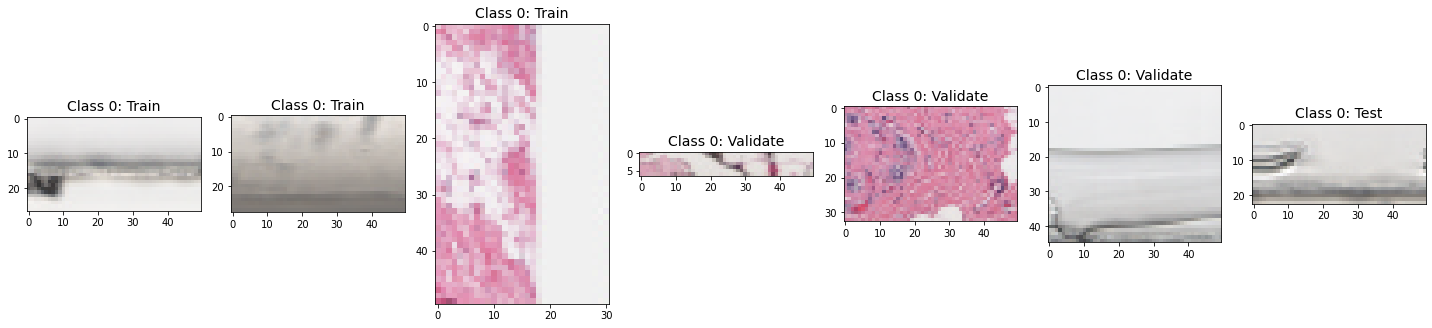

In [19]:
import cv2 as cv
import skimage.io as io

def display_images(subclass):
  fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(20,8))
  for idx, ax in enumerate(axes.flat):
    image_wo_path = os.path.basename(subclass.path[idx])
    # print(image_wo_path)
    subtitle = 'Class ' + image_wo_path.rsplit('.')[0][-1] + ': ' + subclass.dataset[idx]
    img = io.imread(subclass.path[idx])
    ax.imshow(img)
    # ax.axis('off')
    ax.set_title(subtitle, size=14)   
  fig.tight_layout() 
  plt.show() 

print()
display_images(weird_imgs.reset_index(drop=True))

# Preprocessing data using ImageDataGenerator

In [20]:
# https://faroit.com/keras-docs/0.3.3/preprocessing/image/
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

def data_generator(with_augmented_images=False,
                    zca_whitening=False,
                    zca_epsilon=1e-06,
                    rotation_range=10,                             
                    width_shift_range=0.0,
                    height_shift_range=0.0,
                    brightness_range=None,
                    shear_range=0.2,                                  
                    zoom_range=0.2,                                
                    channel_shift_range=0.0,                       
                    fill_mode='nearest',                           
                    cval=0.0,
                    horizontal_flip=True,
                    vertical_flip=False,
                    rescale=None):
  
  with_aug_datagen = ImageDataGenerator(
      featurewise_center = True,                     # transforms the images to 0 mean
      featurewise_std_normalization = True,          # divide inputs by std of the dataset
      zca_whitening=zca_whitening,
      zca_epsilon=zca_epsilon,
      rotation_range=rotation_range,                 # randomly rotate image by 10 degrees
      width_shift_range=width_shift_range,
      height_shift_range=height_shift_range,
      brightness_range=brightness_range,
      shear_range=shear_range,                       # distort image along an axis mostly to create or recify the perception angles     
      zoom_range=zoom_range,                         # zomming image: zoom_range > 1 => zoom out, zoom_range < 1 => zoom in
      channel_shift_range=channel_shift_range,                       
      fill_mode='nearest',                           # when the image is rotated, some pixels will move outside the image and leave an empty area that needs to be filled in, 'nearest': simply replace the empty area with the nearest spectral values.
      cval=cval,
      horizontal_flip=horizontal_flip,
      vertical_flip=vertical_flip,
      rescale=rescale)                               # rescale=1./255

  without_aug_datagen = ImageDataGenerator(
      featurewise_center = True,                     
      featurewise_std_normalization = True)
  
# =================================================================
  if with_augmented_images:
    train_data_generator = with_aug_datagen.flow_from_dataframe(
        train_generator,
        directory = None,
        x_col =  'path',
        y_col =  'label',
        weight_col=None,
        target_size=(50, 50),
        color_mode="grayscale",
        class_mode="categorical",
        batch_size=32,
        shuffle=True,
        seed=1234
        # validate_filenames=True
    )
  else:
    train_data_generator = without_aug_datagen.flow_from_dataframe(
        train_generator,
        directory = None,
        x_col =  'path',
        y_col =  'label',
        weight_col=None,
        target_size=(50, 50),
        color_mode="grayscale",
        class_mode="categorical",
        batch_size=32,
        shuffle=True,
        seed=1234
        # validate_filenames=True
    )

  validation_data_generator = without_aug_datagen.flow_from_dataframe(
      val_generator,
      directory = None,
      x_col =  'path',
      y_col =  'label',
      weight_col=None,
      target_size=(50, 50),
      color_mode="grayscale",
      class_mode="categorical",
      batch_size=32,
      shuffle=True,
      seed=1234
      # validate_filenames=True
  )

  test_data_generator = without_aug_datagen.flow_from_dataframe(
      test_generator,
      directory = None,
      x_col =  'path',
      y_col =  'label',
      weight_col=None,
      target_size=(50, 50),
      color_mode="grayscale",
      class_mode="categorical",
      batch_size=32,
      shuffle=False,              # Kesha set to shuffle=True but we don't want to shuffle our testing data around, which it does so by default
      seed=1234
      # validate_filenames=True
  )
  return train_data_generator, validation_data_generator, test_data_generator

# train_data_generator, validation_data_generator, test_data_generator = data_generator(with_augmented_images=False)

# Build CNN Model

In [21]:
img_height = 50
img_width = 50
img_channel = 1
input_shape = (img_height, img_width, img_channel)

In [22]:
from keras.layers import ReLU, LeakyReLU

# 'Adadelta', 'Adagrad', 'Adam', 'RMSprop', 'SGD'
#  Tanh, Leaky ReLU, Parametric ReLU, ELU, GELU, SELU, Swish 
def build_cnn(kernel_size = (3,3),
              strides = (1,1),
              pool_size = (2,2),
              learning_rate = 0.001,
              optimizer = 'Adam',
              activation = 'relu',
              average_over_position=True,
              batch_normalization=True,
              dropout_layer=True,
              dropout_rate=0.5, 
              filters_1=32,
              filters_2=64,
              filters_3=128,
              dense_units=256,
              conv_layer_2=True,
              conv_layer_3=True):    

  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  model = tf.keras.Sequential()
  model.add(Conv2D(filters=filters_1, kernel_size=kernel_size, padding='same', activation=activation.lower(), input_shape = input_shape))

  def have_batch_normalization(batch_normalization):
    if batch_normalization:
      model.add(BatchNormalization())

  def nn_layer(average_over_position):
    if average_over_position:
      model.add(AveragePooling2D())
    else:
      model.add(MaxPooling2D(pool_size=pool_size, strides=strides))
  
  def have_dropout(dropout_layer):
    if dropout_layer:
      model.add(Dropout(dropout_rate))

  def selected_optimizer(optimizer):
    if optimizer.lower() == 'sgd':
        return SGD(learning_rate=learning_rate)           # SGD(learning_rate=learning_rate, momentum=0.95, decay=1, nesterov=True)
    elif optimizer.lower() == 'adam':
        return Adam(learning_rate=learning_rate)          # Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-8, kappa=1-1e-8)
    elif optimizer.lower() == 'adadelta':
        return Adadelta(learning_rate=learning_rate)      # Adadelta(learning_rate=learning_rate, rho=0.95, epsilon=1e-6)
    elif optimizer.lower() == 'adagrad':
        return Adagrad(learning_rate=learning_rate)       # Adagrad(learning_rate=learning_rate, epsilon=1e-6)
    elif optimizer.lower() == 'rmsprop':
        return RMSprop(learning_rate=learning_rate)       # RMSprop(learning_rate=learning_rate, rho=0.9, epsilon=1e-6)

  if conv_layer_2:  
    model.add(Conv2D(filters=filters_2, kernel_size=kernel_size, padding='same', activation=activation.lower()))
    have_batch_normalization(batch_normalization)
    nn_layer(average_over_position)
    have_dropout(dropout_layer)

  if conv_layer_3:
    model.add(Conv2D(filters=filters_3, kernel_size=kernel_size, padding='same', activation=activation.lower()))
    have_batch_normalization(batch_normalization)
    nn_layer(average_over_position)
    have_dropout(dropout_layer)

  model.add(Flatten())
  model.add(Dense(units = dense_units, activation = activation))
  have_dropout(dropout_layer)
  model.add(Dense(units = 2, activation = 'softmax'))          # output layer

  model.compile(loss=CategoricalCrossentropy(from_logits=True), 
                optimizer=selected_optimizer(optimizer), 
                metrics=['accuracy'])

  return model

In [23]:
# model = build_cnn(kernel_size = (3,3),
#               strides = (1,1),
#               pool_size = (2,2),
#               learning_rate = 0.001,
#               optimizer = 'Adam',                # 'Adadelta', 'Adagrad', 'Adam', 'RMSprop', 'SGD'
#               activation = 'relu',               # Tanh, Leaky ReLU, Parametric ReLU, ELU, GELU, SELU, Swish
#               average_over_position=True,
#               batch_normalization=True,
#               dropout_layer=True,
#               dropout_rate=0.5, 
#               filters_1=32,
#               filters_2=64,
#               filters_3=128,
#               dense_units=256,
#               conv_layer_2=True,
#               conv_layer_3=True)
# model.summary()

# Run Experiments - Hyperparameter Tuning

Found 797 validated image filenames belonging to 2 classes.
Found 197 validated image filenames belonging to 2 classes.
Found 199 validated image filenames belonging to 2 classes.

Training...
Epoch 1/7
25/25 [==============================] - ETA: 0s - loss: 1.5688 - accuracy: 0.6374
Epoch 1: val_accuracy improved from -inf to 0.51777, saving model to weights.hdf5
25/25 [==============================] - 4s 87ms/step - loss: 1.5688 - accuracy: 0.6374 - val_loss: 7.8724 - val_accuracy: 0.5178 - lr: 0.0010
Epoch 2/7
24/25 [===========================>..] - ETA: 0s - loss: 0.6071 - accuracy: 0.7007
Epoch 2: val_accuracy improved from 0.51777 to 0.59898, saving model to weights.hdf5
25/25 [==============================] - 2s 70ms/step - loss: 0.5992 - accuracy: 0.7064 - val_loss: 0.8116 - val_accuracy: 0.5990 - lr: 0.0010
Epoch 3/7
25/25 [==============================] - ETA: 0s - loss: 0.5659 - accuracy: 0.7503
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513

,training_accuracy,val_accuracy,kernel_size
0,0.76,0.68,"(3, 3)"


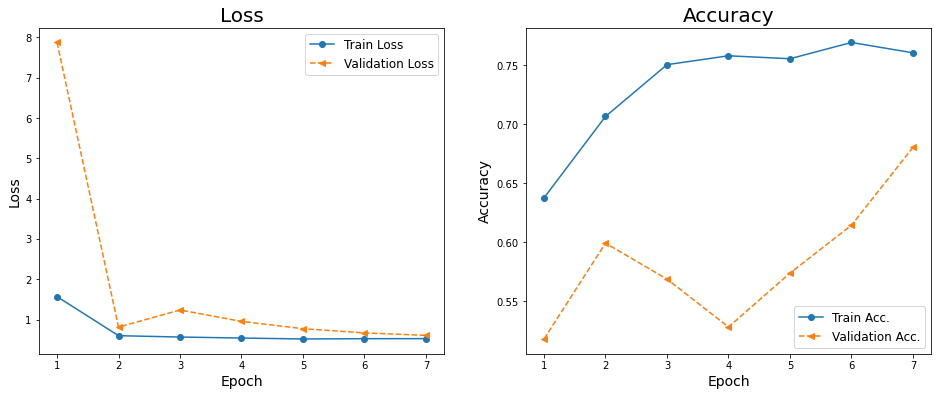

In [50]:
def train_and_evaluate(with_augmented_images=False,
                      zca_whitening=False,
                      zca_epsilon=1e-06,
                      rotation_range=10,                             
                      width_shift_range=0.0,
                      height_shift_range=0.0,
                      brightness_range=None,
                      shear_range=0.2,                                  
                      zoom_range=0.2,                                
                      channel_shift_range=0.0,                       
                      fill_mode='nearest',                           
                      cval=0.0,
                      horizontal_flip=True,
                      vertical_flip=False,
                      rescale=None,
                      kernel_size = (3,3),
                      strides = (1,1),
                      pool_size = (2,2),
                      learning_rate = 0.001,
                      optimizer = 'Adam',                # 'Adadelta', 'Adagrad', 'Adam', 'RMSprop', 'SGD'
                      activation = 'relu',               # Tanh, Leaky ReLU, Parametric ReLU, ELU, GELU, SELU, Swish
                      average_over_position=True,
                      batch_normalization=True,
                      dropout_layer=True,
                      dropout_rate=0.5, 
                      filters_1=32,
                      filters_2=64,
                      filters_3=128,
                      dense_units=256,
                      conv_layer_2=True,
                      conv_layer_3=True,
                      num_epochs=7):
    
    # preprocess the data 
    train_data_generator, validation_data_generator, test_data_generator = data_generator(
                                                                              with_augmented_images = with_augmented_images,
                                                                              zca_whitening = zca_whitening,
                                                                              zca_epsilon = zca_epsilon,
                                                                              rotation_range = rotation_range,                             
                                                                              width_shift_range = width_shift_range,
                                                                              height_shift_range = height_shift_range,
                                                                              brightness_range = brightness_range,
                                                                              shear_range = shear_range,                                  
                                                                              zoom_range = zoom_range,                                
                                                                              channel_shift_range = channel_shift_range,                       
                                                                              fill_mode = fill_mode,                           
                                                                              cval = cval,
                                                                              horizontal_flip = horizontal_flip,
                                                                              vertical_flip = vertical_flip,
                                                                              rescale = rescale)
    # Build model
    model = build_cnn(kernel_size = kernel_size,
              strides = strides,
              pool_size = pool_size,
              learning_rate = learning_rate,
              optimizer = optimizer,                # 'Adadelta', 'Adagrad', 'Adam', 'RMSprop', 'SGD'
              activation = activation,               # Tanh, Leaky ReLU, Parametric ReLU, ELU, GELU, SELU, Swish
              average_over_position = average_over_position,
              batch_normalization = batch_normalization,
              dropout_layer = dropout_layer,
              dropout_rate = dropout_rate, 
              filters_1 = filters_1,
              filters_2 = filters_2,
              filters_3 = filters_3,
              dense_units = dense_units,
              conv_layer_2 = conv_layer_2,
              conv_layer_3 = conv_layer_3)
    
    # Train the model
    print('\nTraining...')
    lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, min_delta=0.0001, patience=1, verbose=1)

    file_path = 'weights.hdf5'    # save the weights and biases
    checkpoint = ModelCheckpoint(file_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    history = model.fit(train_data_generator,
                      epochs=num_epochs,
                      callbacks=[lr_reduce, checkpoint],
                      validation_data = validation_data_generator)

    
    # Plot loss and accuracy on every epoch
    hist = history.history
    x_arr = np.arange(len(hist['loss'])) + 1

    fig = plt.figure(figsize=(16,6))
    ax = fig.add_subplot(1,2,1)
    ax.plot(x_arr, hist['loss'], '-o', label='Train Loss')
    ax.plot(x_arr, hist['val_loss'], '--<', label='Validation Loss')
    ax.legend(fontsize=12)
    ax.set_xlabel('Epoch', size=14)
    ax.set_ylabel('Loss', size=14)
    ax.set_title('Loss', size=20)

    ax = fig.add_subplot(1,2,2)
    ax.plot(x_arr, hist['accuracy'], '-o', label='Train Acc.')
    ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation Acc.')
    ax.legend(fontsize=12)
    ax.set_xlabel('Epoch', size=14)
    ax.set_ylabel('Accuracy', size=14)
    ax.set_title('Accuracy', size=20);
      
    # Test accuracy - model.evaluate
    test_accuracy = round(model.evaluate(test_data_generator, verbose=0,
                             return_dict=True)['accuracy'], 2)
    training_accuracy = round(history.history['accuracy'][-1], 2)
    val_accuracy = round(history.history['val_accuracy'][-1], 2)
    count_params = model.count_params()
    print('test_accuracy: ', test_accuracy,
          '\ntraining_accuracy: ', training_accuracy,
          '\nval_accuracy: ', val_accuracy,
          '\ncount_params: ', f'{count_params:,}',
          '\nkernel_size', kernel_size,
          '\nstrides', strides,
          '\npool_size', pool_size,
          '\nlearning_rate', learning_rate,
          '\noptimizer', optimizer,                
          '\nactivation', activation,  
          '\nrescale', rescale,          
          '\naverage_over_position', average_over_position,
          '\nbatch_normalization', batch_normalization,
          '\ndropout_layer', dropout_layer,
          '\ndropout_rate', dropout_rate, 
          '\nfilters_1', filters_1,
          '\nfilters_2', filters_2,
          '\nfilters_3', filters_3,
          '\ndense_units', dense_units,
          '\nconv_layer_2', conv_layer_2,
          '\nconv_layer_3', conv_layer_3,
          '\nnum_epochs', num_epochs,
          '\nwith_augmented_images', with_augmented_images,
          '\nzca_whitening', zca_whitening,
          '\nzca_epsilon', zca_epsilon,
          '\nrotation_range', rotation_range,                             
          '\nwidth_shift_range', width_shift_range,
          '\nheight_shift_range', height_shift_range,
          '\nbrightness_range', brightness_range,
          '\nshear_range', shear_range,                                  
          '\nzoom_range', zoom_range,                                
          '\nchannel_shift_range', channel_shift_range,                       
          '\nfill_mode', fill_mode,                           
          '\ncval', cval,
          '\nhorizontal_flip', horizontal_flip,
          '\nvertical_flip', vertical_flip)
    

    a = ['training_accuracy', 'val_accuracy', 'kernel_size']
    b = [training_accuracy, val_accuracy, kernel_size]
    df = pd.DataFrame({'0':a, '1':b}).T
    df.rename(columns=df.iloc[0], inplace = True)

    # model_summary = pd.DataFrame({'Model':training_accuracy,
    #                             'Accuracy': val_accuracy,
    #                             'Recall': kernel_size}, index=[0]) 
    
    # optimizer = 'Adadelta', 'Adagrad', 'Adam', 'RMSprop', 'SGD'
    # activation = Tanh, Leaky ReLU, Parametric ReLU, ELU, GELU, SELU, Swish
    # experiments = pd.DataFrame({'test_accuracy: ', test_accuracy,
          # 'training_accuracy': training_accuracy,
          #                       'validation_accuracy': val_accuracy,
          #                       'test_accuracy': test_accuracy,
          #                       'num_params': f'{count_params:,}',
          #                       'kernel_size': kernel_size,
          #                       'strides': strides,
          #                       'pool_size': pool_size,
          #                       'learning_rate': learning_rate,
          #                       'optimizer': optimizer,                
          #                       'activation': activation,  
          #                       'rescale': rescale}, index=[0])              
          #                             'average_over_position': average_over_position,
          #                             'batch_normalization': batch_normalization,
          #                             'dropout_layer': dropout_layer,
          #                             'dropout_rate': dropout_rate, 
          #                             'filters_1': filters_1,
          #                             'filters_2': filters_2,
          #                             'filters_3': filters_3,
          #                             'dense_units': dense_units,
          #                             'conv_layer_2': conv_layer_2,
          #                             'conv_layer_3': conv_layer_3,
          #                             'num_epochs': num_epochs,
          #                             'with_augmented_images': with_augmented_images,
          #                             'zca_whitening': zca_whitening,
          #                             'zca_epsilon': zca_epsilon,
          #                             'rotation_range': rotation_range,                             
          #                             'width_shift_range': width_shift_range,
          #                             'height_shift_range': height_shift_range,
          #                             'brightness_range': brightness_range,
          #                             'shear_range': shear_range,                                  
          #                             'zoom_range': zoom_range,                                
          #                             'channel_shift_range': channel_shift_range,                       
          #                             'fill_mode': fill_mode,                           
                                      # 'cval': cval,
                                      # 'horizontal_flip': horizontal_flip,
                                      # 'vertical_flip': vertical_flip,
                                      
    return df.iloc[1:, :].reset_index(drop=True)   

train_and_evaluate(with_augmented_images=False,
                      zca_whitening=False,
                      zca_epsilon=1e-06,
                      rotation_range=10,                             
                      width_shift_range=0.0,
                      height_shift_range=0.0,
                      brightness_range=None,
                      shear_range=0.2,                                  
                      zoom_range=0.2,                                
                      channel_shift_range=0.0,                       
                      fill_mode='nearest',                           
                      cval=0.0,
                      horizontal_flip=True,
                      vertical_flip=False,
                      rescale=None,
                      kernel_size = (3,3),
                      strides = (1,1),
                      pool_size = (2,2),
                      learning_rate = 0.001,
                      optimizer = 'Adam',                # 'Adadelta', 'Adagrad', 'Adam', 'RMSprop', 'SGD'
                      activation = 'relu',               # Tanh, Leaky ReLU, Parametric ReLU, ELU, GELU, SELU, Swish
                      average_over_position=True,
                      batch_normalization=True,
                      dropout_layer=True,
                      dropout_rate=0.5, 
                      filters_1=32,
                      filters_2=64,
                      filters_3=128,
                      dense_units=256,
                      conv_layer_2=True,
                      conv_layer_3=True,
                      num_epochs=7)

# c While Training the Model
- **ReduceLROnPlateau**: A scheduling technique that monitors a particular quantity and decays the learning rate when the quantity is stop improving.
- **ModelCheckpoint**: A sch
- **BatchNormalization**: A feature that we add between the layers of neural network and it continuously takes the output from the previous layer and normalizes it before sending it to the next layer thereby helping stablizing the NN

In [ ]:
# def model_fit(model, train_data_generator, validation_data_generator, epochs=7):  
#   lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, min_delta=0.0001, patience=1, verbose=1)

#   file_path = 'weights.hdf5'    # save the weights and biases
#   checkpoint = ModelCheckpoint(file_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
#   history = model.fit(train_data_generator,
#                     epochs=epochs,
#                     callbacks=[lr_reduce, checkpoint],
#                     validation_data = validation_data_generator)
#   return history

In [ ]:
def model_fit_and_plot_loss_acc(epochs=7):
  history = model_fit(model, train_data_generator, validation_data_generator, epochs=epochs)
  hist = history.history
  x_arr = np.arange(len(hist['loss'])) + 1

  fig = plt.figure(figsize=(16,6))
  ax = fig.add_subplot(1,2,1)
  ax.plot(x_arr, hist['loss'], '-o', label='Train Loss')
  ax.plot(x_arr, hist['val_loss'], '--<', label='Validation Loss')
  ax.legend(fontsize=12)
  ax.set_xlabel('Epoch', size=14)
  ax.set_ylabel('Loss', size=14)
  ax.set_title('Loss', size=20)

  ax = fig.add_subplot(1,2,2)
  ax.plot(x_arr, hist['accuracy'], '-o', label='Train Acc.')
  ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation Acc.')
  ax.legend(fontsize=12)
  ax.set_xlabel('Epoch', size=14)
  ax.set_ylabel('Accuracy', size=14)
  ax.set_title('Accuracy', size=20);

  print('train_acc: ', round(history.history['accuracy'][-1], 2))
  print('val_acc: ', round(history.history['val_accuracy'][-1], 2))
    # val_acc = history.history['val_accuracy'])

model_fit_and_plot_loss_acc(epochs=8)

In [ ]:
def model_evaluate(model, train_data_generator, test_data_generator):
  eval_train = model.evaluate(train_data_generator)
  print(f'Train Accuracy: {eval_train[1]*100:.2f}%')
  print()
  eval_test = model.evaluate(test_data_generator)
  print(f'Test Accuracy: {eval_test[1]*100:.2f}%\n')

model_evaluate(model, train_data_generator, test_data_generator)

- **Cohen Kappa:**</font> a score that expresses the level of agreement between Observed Accuracy with an Expected Accuracy (random chance). value <= 0 means *no agreement* and close to 1 means almsot perfect agreement (the higher ck value, the higher agreement between the OA and EA. 
- **Zero-One Loss:**</font> return the fraction of misclassifications (float), else it returns the number of misclassifications (int). The best performance is 0.

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, classification_report

def error_analysis(model_name, model, test_labels, test_data_generator):
  num_of_test_samples = len(test_labels)
  batch_size = 32
  classes = ['Non-IDC(0)','IDC(1)']

  y_true = test_data_generator.classes
  y_pred = model.predict_generator(test_data_generator, num_of_test_samples // batch_size + 1)
  y_pred = np.argmax(y_pred, axis=1)     # return the indicies of the max values along the axis (axis=1: each row)

  # Confusion matrix  
  conf_max = confusion_matrix(y_true, y_pred)
  perf_conf_max = conf_max.astype('float')/conf_max.sum(axis=1)[:np.newaxis]*100
  df_perf_conf_max = pd.DataFrame(perf_conf_max, index=classes, columns=classes)

  plt.figure(figsize=(6,5))
  sns.heatmap(df_perf_conf_max, annot=True, cmap='coolwarm', annot_kws={'fontsize':16}, linewidth=0.5, fmt='.0f')  
  plt.xlabel('Predicted Label', fontsize=14)
  plt.ylabel('True Label', fontsize=14)
  plt.title('Confusion Matrix (%)', fontsize=15)
  
  # Classification report
  print('=============== Classification Report ===============\n\n', classification_report(y_true, y_pred, target_names=['Non-IDC', 'IDC']), '\n=====================================================\n')
  
  # Cross validation score
  # cv = ShuffleSplit(n_splits=100, test_size=.25, random_state=0)
  # cv_score = np.median(cross_val_score(model, y_true, y_pred, cv=cv))*100
  # print('cv_score = ',cv_score)

  # Precision, recall, and f1_score
  tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()     # np.ravel(): returns contiguous flattened array (1D array with all the input-array elements and with the same type as it)
  accuracy = round(accuracy_score(y_true, y_pred), 2)
  precision = round(precision_score(y_true, y_pred), 2)
  recall = round(tp/(tp+fn), 2)
  f1score = round((2*precision*recall)/(precision+recall), 2)

  # cohen_kappa score and zero_one loss
  cohen_kappa = round(cohen_kappa_score(y_true, y_pred), 2)
  zo_loss = round(zero_one_loss(y_true, y_pred), 2)

  # Area under the ROC cuver
  roc_log = roc_auc_score(y_true, y_pred)
  false_positive_rate, true_positive_rate, threshold = roc_curve(y_true, y_pred)
  area_under_curve = round(auc(false_positive_rate, true_positive_rate), 2)

  plt.figure(figsize=(6,5))
  plt.plot([0, 1], [0, 1], 'r--')  
  plt.plot(false_positive_rate, true_positive_rate, label='ROC-AUC = {:.2f}'.format(area_under_curve))  
  plt.xlabel('False positive rate', fontsize=14)
  plt.ylabel('True positive rate', fontsize=14)
  plt.title('ROC Curve', fontsize=18)
  plt.legend(loc='best')
  plt.show()
  # plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
  plt.close()

  model_summary = pd.DataFrame({'Model':model_name,
                                'Zero-One Loss': zo_loss}, index=[0]) 
  return model_summary
  
error_analysis('CNN', model, test_labels, test_data_generator)

# Transfer Learning
- **ResNet152V2**
- **VGG16**
- **VGG19**

In [ ]:
from tensorflow.keras.applications import ResNet152V2, VGG16, VGG19

# https://keras.io/api/applications/
tf.keras.backend.clear_session()
tf.random.set_seed(1234)

input_shape = (50,50,3)
vgg16_base_model = VGG16(input_shape=input_shape, include_top=False, weights='imagenet')
vgg19_base_model = VGG19(input_shape=input_shape, include_top=False, weights='imagenet')
resnet_base_model = ResNet152V2(input_shape=input_shape, include_top=False, weights='imagenet')

# vgg16_base_model.summary()
# vgg19_base_model.summary()
# resnet_base_model.summary()

In [ ]:
def build_cnn_tl(model_tl):
  return tf.keras.Sequential([
                           model_tl,                           
                           Flatten(),

                           Dense(units = 1024, activation = 'relu'),
                           BatchNormalization(),                           
                           Dropout(rate=0.5),

                           Dense(units = 128, activation = 'relu'),
                           BatchNormalization(),                           
                           Dropout(rate=0.4),

                           Dense(units = 2, activation = 'softmax')
])  

In [ ]:
# freeze initial layer of the network, making only the fully connected layer we added trainable
vgg16_base_model.trainable = False
vgg19_base_model.trainable = False
resnet_base_model.trainable = False

# run each model
model_vgg16 = build_cnn_tl(vgg16_base_model)
model_vgg19 = build_cnn_tl(vgg19_base_model)
model_resnet = build_cnn_tl(resnet_base_model)

In [ ]:
def model_compile_tl(model_tl, optimizer='Adam', learning_rate = 0.001):
  # select optimizer
  def selected_optimizer(optimizer):
      if optimizer.lower() == 'sgd':
          return SGD(learning_rate=learning_rate)
      if optimizer.lower() == 'adam':
          return Adam(learning_rate=learning_rate)

  model_tl.compile(optimizer=selected_optimizer(optimizer), 
                      loss=keras.losses.categorical_crossentropy, 
                      metrics=['accuracy'])
  model_tl.summary()
  return model_tl

model_vgg16 = model_compile_tl(model_vgg16, optimizer='Adam', learning_rate = 0.001)
# model_vgg19 = model_compile_tl(model_vgg19, optimizer='Adam', learning_rate = 0.001)
model_resnet = model_compile_tl(model_resnet, optimizer='Adam', learning_rate = 0.001)

In [ ]:
# def model_fit_tl(model_tl, train_data_generator, validation_data_generator, epochs=10):
#   lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, min_delta=0.0001, patience=1, verbose=1)

#   file_path = 'weights.hdf5'    # save the weights and biases
#   checkpoint = ModelCheckpoint(file_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

#   history = model_tl.fit(np.repeat(train_data_generator, 3, -1),
#                   epochs = epochs,
#                   callbacks = [lr_reduce, checkpoint],
#                   validation_data = np.repeat(validation_data_generator, 3, -1))
#   return history
# history_tl = model_fit_tl(model_vgg16, train_data_generator, validation_data_generator, 10)

In [ ]:
# def model_fit_and_plot_loss_acc(model_tl):
#   history = model_fit_tl(model_tl, train_data_generator, validation_data_generator, 10)
#   hist = history.history
#   x_arr = np.arange(len(hist['loss'])) + 1

#   fig = plt.figure(figsize=(16,6))
#   ax = fig.add_subplot(1,2,1)
#   ax.plot(x_arr, hist['loss'], '-o', label='Train Loss')
#   ax.plot(x_arr, hist['val_loss'], '--<', label='Validation Loss')
#   ax.legend(fontsize=12)
#   ax.set_xlabel('Epoch', size=14)
#   ax.set_ylabel('Loss', size=14)
#   ax.set_title('Loss', size=20)

#   ax = fig.add_subplot(1,2,2)
#   ax.plot(x_arr, hist['accuracy'], '-o', label='Train Acc.')
#   ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation Acc.')
#   ax.legend(fontsize=12)
#   ax.set_xlabel('Epoch', size=14)
#   ax.set_ylabel('Accuracy', size=14)
#   ax.set_title('Accuracy', size=20);

# # model_fit_and_plot_loss_acc(model_vgg16)
# # model_fit_and_plot_loss_acc(model_vgg19)
# model_fit_and_plot_loss_acc(model_vgg16)

In [ ]:
# model_compile_tl(model_resnet, optimizer='Adam', learning_rate = 0.001)
# model_fit_tl(model_resnet, train_data_generator, validation_data_generator, epochs=7)
# plot_loss_acc(history_tl)
# model_evaluate(model_resnet, train_data_generator, test_data_generator)
# error_analysis(test_labels, test_data_generator)

In [ ]:
# plot_loss_acc(history_tl)

In [ ]:
# model_evaluate(model_resnet, train_data_generator, test_data_generator)

In [ ]:
# error_analysis(test_labels, test_data_generator)